# Machine Learning Engineer Nanodegree
## Unsupervised Learning
## Project: Creating Customer Segments

## Getting Started

In this project, you will analyze a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a whole sale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, silhouette_score, make_scorer
from seaborn import heatmap
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

# supplementary visualizations code
import visuals as vs

np.random.seed(1234)

%matplotlib inline

try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print("Wholesale customers dataset has {} samples with {} features each.".format(*data.shape))
    display(data.head())
except:
    print("Dataset could not be loaded. Is the dataset missing?")

Wholesale customers dataset has 440 samples with 6 features each.


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


## Data Exploration
We will now begin exploring the data through visualizations and code to understand how each feature is related to the others. We will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which you will track through the course of this project.

In [2]:
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Implementation: Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, we will select a few sample data points and explore them in more detail.

In [3]:
indices = [46, 150, 383]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print("Chosen samples of wholesale customers dataset:")
display(samples)

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,3103,14069,21955,1668,6792,1452
1,16225,1825,1765,853,170,1067
2,1821,1364,3450,4006,397,361


### Question 1
Consider the total purchase cost of each product category and the statistical description of the dataset above for your sample customers.  

* What kind of establishment (customer) could each of the three samples you've chosen represent?


In [4]:
# subtract the mean of each column to every sample
compare = dict()
for col in samples.columns:
    compare[col] = ["{:.2f}".format(samples[col][x] - data.describe()[col][1]) for x in range(3)]
display(pd.DataFrame.from_dict(compare))

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,-8897.30,8272.73,14003.72,-1403.93,3910.51,-72.87
1,4224.70,-3971.27,-6186.28,-2218.93,-2711.49,-457.87
2,-10179.30,-4432.27,-4501.28,934.07,-2484.49,-1163.87


**Answer:**

By looking at the data, the first coming up is a large standard deviation for every column.
In the cell above we have subtracted the mean of each column to every customer purchase.

In the first sample we can see that Detergents_Paper, Grocery and Milk are much above the mean and those are products that can be found most in a market, so i would label it as a market.

In the second sample only the fresh products are high, so it can either be a restaurant or a retailer, but it buys also frozen products, so i think restaurant would be a better choice.

In the last sample only frozen products have a positive number, so for the same theory of the sample 2 i would label it as a restaurant.

One thing to notice is that the first sample (labeled as market) tends to buy a lot of milk, grocery and detergents and not much of the rest, but the other 2 samples (labeled as restaurants) tend to buy either fresh or frozen products and in both cases there are very less detergents, milk and grocery, so this might be an information to consider.

### Implementation: Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products?

In [5]:
for feature in ["Fresh", "Frozen","Delicatessen", "Milk", "Grocery", "Detergents_Paper"]:
    # copy of the DataFrame
    new_data = data.drop([feature], axis=1)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(new_data, data[feature], test_size=0.25, random_state=42)

    # Create a decision tree regressor
    regressor = DecisionTreeRegressor(max_depth=5, random_state=42)
    regressor.fit(X_train, y_train)

    # Report the score
    score = r2_score(y_test, regressor.predict(X_test))

    print("{} has a score of {:.4f}".format(feature, score))

Fresh has a score of -0.2329
Frozen has a score of 0.0466
Delicatessen has a score of -10.3006
Milk has a score of 0.4110
Grocery has a score of 0.7495
Detergents_Paper has a score of 0.4767


### Question 2

* Which feature did you attempt to predict? 
* What was the reported prediction score? 
* Is this feature necessary for identifying customers' spending habits?

**Answer:**
In the code above i tried to predict the feature "Fresh", "Frozen","Delicatessen", "Milk", "Grocery", "Detergents_Paper" as supposed in the previous question and the score is respectively -0.2329, 0.0466, -10.3006, 0.35, 0.76 and 0.43.
By these informations we can observe that the feature Grocery is easily predictible, which means it doesn' t give us many informations, but Milk and Detergents_Papers are very difficult to predict, making them 2 relevant features. Finally, the remaining 3 features have a negative score, this sign shows us no correlation with the other features.

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data.

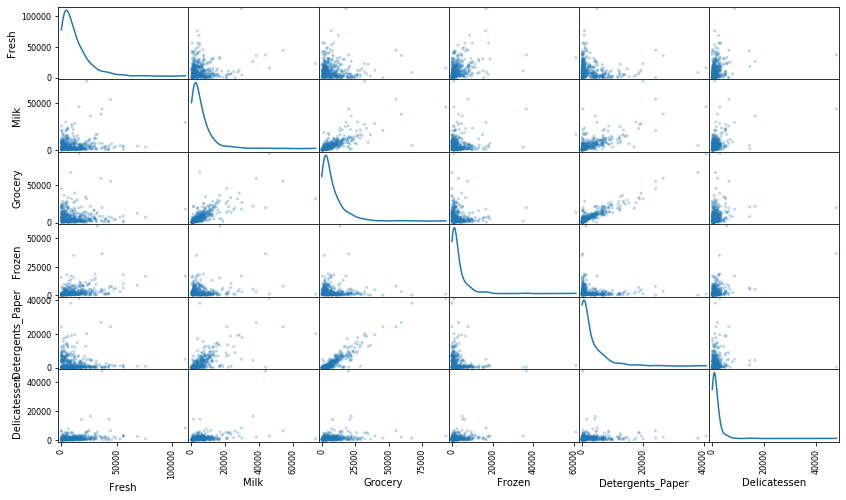

In [6]:
pd.plotting.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Question 3
* Using the scatter matrix as a reference, discuss the distribution of the dataset, specifically talk about the normality, outliers, large number of data points near 0 among others. If you need to sepearate out some of the plots individually to further accentuate your point, you may do so as well.
* Are there any pairs of features which exhibit some degree of correlation? 
* Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict? 
* How is the data for those features distributed?

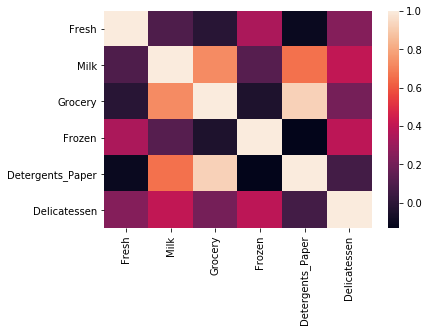

In [7]:
heatmap(data.corr())

**Answer:**
As we can see in the scatter matrix above, the data is not normally distributed because it tends to concentrate in one area, more specifically around 0.
We can also see the presence of many outliers in every feature, because these are  far away from the majority of the points.
From the graph above we can also notice the correlation between the features "milk", "grocery" and "detergents_papers", specially between the pairs grocery-milk and grocery-detergents_papers.
In the scatter matrix we can also see that the correlation grocery-milk and the correlation grocery-detergents_papers is for both linear, so 1 degree.

## Data Preprocessing
Now we will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting and optionally removing outliers. Preprocessing data is often times a critical step in assuring that results you obtain from your analysis are significant and meaningful.

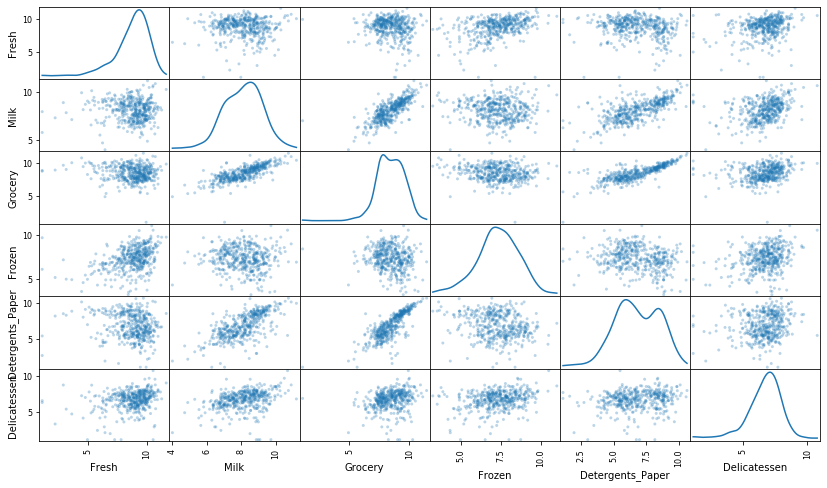

In [8]:
# Scale data and samples using the natural logarithm
log_data = np.log(data)
log_samples = np.log(samples)

pd.plotting.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature appear much more normal.

In [10]:
# Display the log-transformed sample data
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,8.040125,9.551729,9.996750,7.419381,8.823501,7.280697
1,9.694309,7.509335,7.475906,6.748760,5.135798,6.972606
2,7.507141,7.218177,8.146130,8.295549,5.983936,5.888878


### Feature Relevance
Let's test feature relevance again on the transformed data with another algorithm to see if it can perform better than before. This transformation should have helped our model.

In [9]:
for feature in ["Fresh", "Frozen","Delicatessen", "Milk", "Grocery", "Detergents_Paper"]:
    # copy of the DataFrame
    new_data = log_data.drop([feature], axis=1)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(new_data, log_data[feature], test_size=0.25, random_state=42)

    # Create a Epsilon-Support Vector Regression
    degree = 2
    if feature == "Grocery":
        degree = 3
    regressor = SVR(kernel="poly", degree=degree, C=1.0, epsilon=0.6)
    regressor.fit(X_train, y_train)

    # Report the score
    score = r2_score(y_test, regressor.predict(X_test))

    print("{} has a score of {:.4f}".format(feature, score))

Fresh has a score of 0.1022
Frozen has a score of 0.2332
Delicatessen has a score of 0.2213
Milk has a score of 0.7036
Grocery has a score of 0.7428
Detergents_Paper has a score of 0.6501


### Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points.

In [11]:
# indices for data points to remove
outliers  = []


for feature in log_data.keys():
    
    # 25th percentile of the data
    Q1 = np.percentile(log_data[feature], 25)
    
    # 75th percentile of the data
    Q3 = np.percentile(log_data[feature], 75)
    
    # interquartile range to calculate an outlier step
    step = (Q3 - Q1) * 1.5
    
    # Find outliers
    counter = 0
    indices = []
    for x, sample in enumerate(log_data[feature]):
        if not ((Q1 - step) <= sample <= (Q3 + step)):
            outliers.append(x)
            indices.append(x)
            counter += 1

    # Display the outliers
    print("{} Data points considered outliers for the feature '{}':".format(counter, feature))
    display(pd.DataFrame(data.loc[indices], columns = data.keys()))

# print and remove duplicates
ref_list = list()
for x in outliers:
    c = outliers.count(x)
    if c > 1 and x not in ref_list:
        print("The outlier at index {} as been found in {} features.".format(x, c))
        ref_list.append(x)
outliers = list(set(outliers))

# Remove outliers
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

16 Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,85,20959,45828,36,24231,1423
66,9,1534,7417,175,3468,27
81,219,9540,14403,283,7818,156
95,3,2920,6252,440,223,709
96,23,2616,8118,145,3874,217
128,140,8847,3823,142,1062,3
171,200,25862,19816,651,8773,6250
193,180,3485,20292,959,5618,666
218,18,7504,15205,1285,4797,6372
304,161,7460,24773,617,11783,2410


4 Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,22925,73498,32114,987,20070,903
98,503,112,778,895,56,132
154,622,55,137,75,7,8
356,22686,134,218,3157,9,548


2 Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,20398,1137,3,4407,3,975
154,622,55,137,75,7,8


10 Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,4591,15729,16709,33,6956,433
57,5417,9933,10487,38,7572,1282
65,85,20959,45828,36,24231,1423
145,22039,8384,34792,42,12591,4430
175,2343,7845,11874,52,4196,1697
264,1073,9679,15445,61,5980,1265
325,32717,16784,13626,60869,1272,5609
420,4456,5266,13227,25,6818,1393
429,8607,1750,3580,47,84,2501
439,2787,1698,2510,65,477,52


2 Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,20398,1137,3,4407,3,975
161,12434,540,283,1092,3,2233


14 Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,9,1534,7417,175,3468,27
109,1406,16729,28986,673,836,3
128,140,8847,3823,142,1062,3
137,3087,8080,8282,661,721,36
142,37036,7152,8253,2995,20,3
154,622,55,137,75,7,8
183,36847,43950,20170,36534,239,47943
184,327,918,4710,74,334,11
187,2438,8002,9819,6269,3459,3
203,583,685,2216,469,954,18


The outlier at index 65 as been found in 2 features.
The outlier at index 66 as been found in 2 features.
The outlier at index 128 as been found in 2 features.
The outlier at index 154 as been found in 3 features.
The outlier at index 75 as been found in 2 features.


### Question 4
* Are there any data points considered outliers for more than one feature based on the definition above? 
* Should these data points be removed from the dataset?

**Answer:**
By executing the code above we can see that the outliers at index 65,66,75,128,154 have been detected as outliers from more than 1 category and this is another prove that these features are correlated.
Outliers are considerated as exceptions, this means we should always remove them, specially in cases where the algorithms we are using are sensitive to them.
For example k-means would be really affected from outliers because of how it works, it minimizes the sum of the distances between the centroid and all the points assigned to it.
This will result in a wrong position of the centroid.

## Feature Transformation
In this section we will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### Implementation: PCA


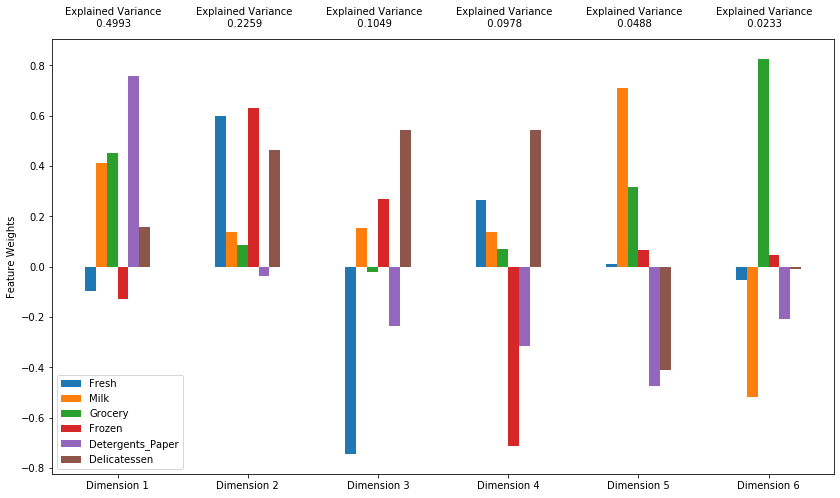

In [12]:
pca = PCA(n_components=6).fit(good_data)
pca_samples = pca.transform(log_samples)

pca_results = vs.pca_results(good_data, pca)

### Question 5

* How much variance in the data is explained* **in total** *by the first and second principal component? 
* How much variance in the data is explained by the first four principal components? 
* Talk about each dimension and the cumulative variance explained by each, stressing upon which features are well represented by each dimension(both in terms of positive and negative variance explained). Discuss what the first four dimensions best represent in terms of customer spending.

**Answer:**
By the first and second principal components there is 72.52% of variance in total and by the first four PCs there is 92.79% of variance.
In the dimension 1 we can see that the features more weighted are "detergents_paper", "grocery" and "milk", while the others are not really relevant.
In the second dimension there are "delicatessen", "frozen" and "fresh" as relevant features while the others are not relevant.
We can see that only with those 2 dimensions most of the variance is obtained and the relevant features in each dimension are complementary.
In the dimension number 3 the most relevant feature is "delicatessen" followed by "frozen", but there are the features "fresh" and "detergents_paper" significatly negative-weighted.
Finally in the 4th dimension the most relevant features are "delicatessen" and "fresh" and also in this dimension we can see 2 features significatly negative-weighted, "frozen" and "detergents_paper".

In [13]:
# Display sample after PCA transformation
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,3.0101,-0.0669,0.6336,-0.3042,0.3419,0.1840
1,-1.8912,0.0059,-0.3431,1.1520,-0.0586,-0.1939
2,-1.2200,-0.8506,0.8543,-1.3849,0.0718,0.5362


### Implementation: Dimensionality Reduction

In [14]:
# Apply PCA with two dimensions
pca = PCA(n_components=2)
pca.fit(good_data)
reduced_data = pca.transform(good_data)
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

# Transform log_samples
pca_samples = pca.transform(log_samples)

display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,3.0101,-0.0669
1,-1.8912,0.0059
2,-1.2200,-0.8506


## Visualizing a Biplot
A biplot is a scatterplot where each data point is represented by its scores along the principal components. In addition, the biplot shows the projection of the original features along the components. A biplot can help us interpret the reduced dimensions of the data, and discover relationships between the principal components and original features.

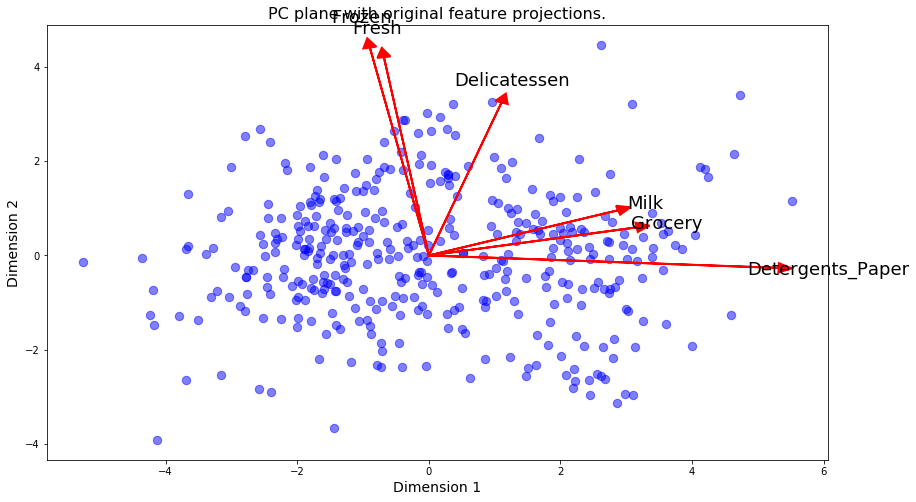

In [15]:
# Create a biplot
vs.biplot(good_data, reduced_data, pca)

### Observation

Once we have the original feature projections, it is easier to interpret the relative position of each data point in the scatterplot.

## Clustering

In this section, you will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. You will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### Question 6

* What are the advantages to using a K-Means clustering algorithm? 
* What are the advantages to using a Gaussian Mixture Model clustering algorithm? 
* Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?

**Answer:**

Advantages of K-Means clustering:

    1) practically work well even some assumptions are broken
    
    2) simple, easy to implement
    
    3) easy to interpret the clustering results
    
    4) computationally efficient

Advantages of GMM clustering:

    1) soft-clustering
    
    2) cluster shape flexibility
    
I will use GMM in this case because we don't have well distinguished clusters so I can have more flexibility in the cluster shape.

### Implementation: Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. 

In [16]:
clusterer = GaussianMixture(n_components=2, covariance_type="diag").fit(reduced_data)

# Predict the cluster
preds = clusterer.predict(reduced_data)

# Find the means
centers = clusterer.means_

# Predict the cluster for each transformed sample data point
sample_preds = clusterer.predict(pca_samples)

# Calculate the mean silhouette coefficient
score = silhouette_score(reduced_data, preds)

print("GMM with {} clusters has a score of {:.4f}.".format(2, score))

GMM with 2 clusters has a score of 0.4501.


### Question 7

* Report the silhouette score for several cluster numbers you tried. 
* Of these, which number of clusters has the best silhouette score?

**Answer:**

GMM with 2 clusters has a score of 0.4501.

GMM with 3 clusters has a score of 0.3605.

GMM with 4 clusters has a score of 0.3103.

We will then decide to divide the data in 2 clusters.

### Cluster Visualization
Once you've chosen the optimal number of clusters for your clustering algorithm using the scoring metric above, you can now visualize the results.

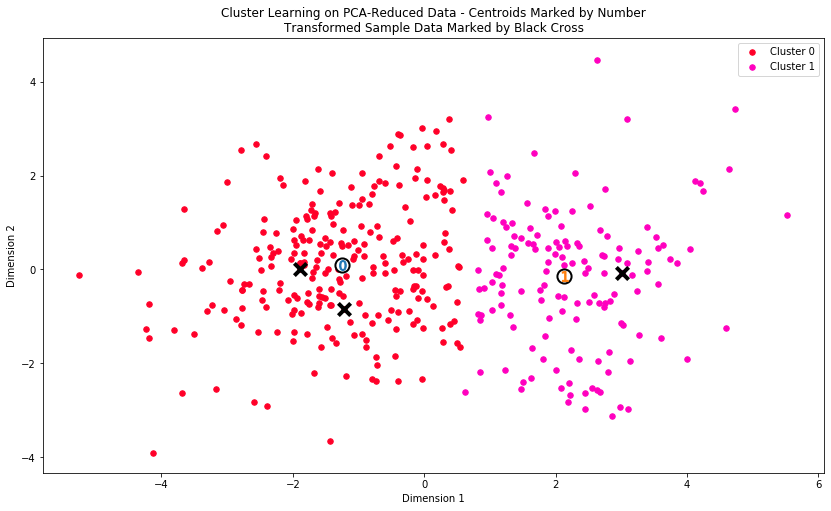

In [17]:
vs.cluster_results(reduced_data, preds, centers, pca_samples)

### Implementation: Data Recovery
Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In [18]:
# Inverse transform the centers
log_centers = pca.inverse_transform(centers)
true_centers = np.exp(log_centers)

# Display centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,9010.0,2040.0,2600.0,2085.0,343.0,768.0
Segment 1,5647.0,7909.0,11688.0,1171.0,4489.0,1176.0


### Question 8

* Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project(specifically looking at the mean values for the various feature points). What set of establishments could each of the customer segments represent?

In [19]:
# subtract the mean of each column to each cluster
compare = dict()
for col in samples.columns:
    compare[col] = ["{:.2f}".format(true_centers[col][x] - data.describe()[col][1]) for x in range(2)]
compare = pd.DataFrame.from_dict(compare)
compare.index = segments
display(compare)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,-2990.30,-3756.27,-5351.28,-986.93,-2538.49,-756.87
Segment 1,-6353.30,2112.73,3736.72,-1900.93,1607.51,-348.87


**Answer:**

As we can see from the data above, the cluster 0 buys a lot of "detergents_paper", "grocery" and "milk", so as assumed at the very beginning, a customer assigned to it will represent a market.
The cluster 1 buys more "fresh" and "frozen" comparing to cluster 0, so as assumed at the very beginning, a customer assigned to it will represent a restaurant.

### Question 9

* For each sample point, which customer segment from* **Question 8** *best represents it? 
* Are the predictions for each sample point consistent with this?*

In [20]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print("Sample point", i, "predicted to be in Cluster", pred)

Sample point 0 predicted to be in Cluster 1
Sample point 1 predicted to be in Cluster 0
Sample point 2 predicted to be in Cluster 0


**Answer:**
Yes, all of them are correctly classified.

## Conclusion

In this final section, you will investigate ways that you can make use of the clustered data. First, you will consider how the different groups of customers, the ***customer segments***, may be affected differently by a specific delivery scheme. Next, you will consider how giving a label to each customer (which *segment* that customer belongs to) can provide for additional features about the customer data. Finally, you will compare the ***customer segments*** to a hidden variable present in the data, to see whether the clustering identified certain relationships.

### Question 10
The wholesale distributor is considering changing its delivery service from currently 5 days a week to 3 days a week. However, the distributor will only make this change in delivery service for customers that react positively. 

* How can the wholesale distributor use the customer segments to determine which customers, if any, would react positively to the change in delivery service?*

**Answer:**

The cluster 1 buy more fresh food than cluster 0, which will result in lower quality.
The cluster 0 is surely a better choice, but more specifically we look at how many fresh products they buy.

### Question 11
Additional structure is derived from originally unlabeled data when using clustering techniques. Since each customer has a ***customer segment*** it best identifies with (depending on the clustering algorithm applied), we can consider *'customer segment'* as an **engineered feature** for the data. Assume the wholesale distributor recently acquired ten new customers and each provided estimates for anticipated annual spending of each product category. Knowing these estimates, the wholesale distributor wants to classify each new customer to a ***customer segment*** to determine the most appropriate delivery service.  
* How can the wholesale distributor label the new customers using only their estimated product spending and the **customer segment** data?

**Answer:**
We can train a desicion tree classifier using estimates as features and customer segment as label.

### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier to the original dataset.

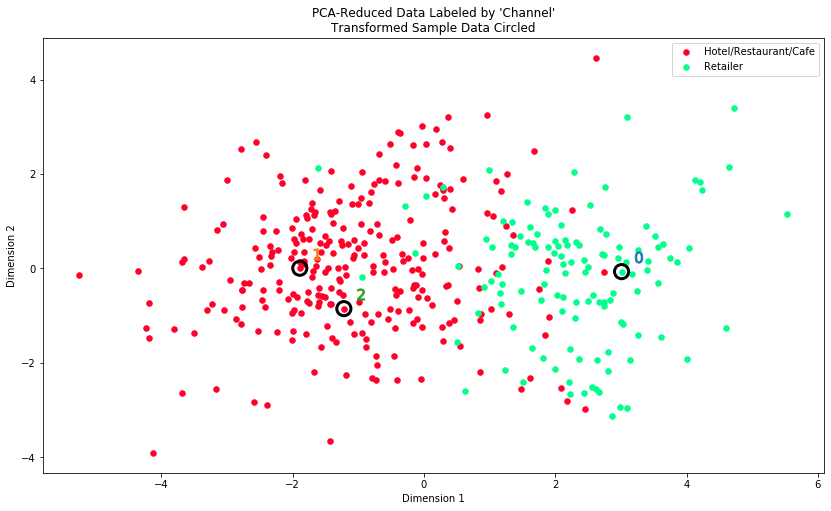

In [21]:
# Display the clustering results based on 'Channel' data
vs.channel_results(reduced_data, outliers, pca_samples)

### Question 12

* How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers? 
* Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution? 
* Would you consider these classifications as consistent with your previous definition of the customer segments?

**Answer:**

The clustering algorithm I've choosen is preatty good compared with the one above, because it labels most of the data points correctly.
No there are no purely customers segments in the  distribution above, because we can see data points overlapping.
Yes classifications are consistent.